## Percobaan 2

Ekualisasi, Median, Gauss

In [ ]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [12]:
data = []
labels = []
file_name = []

for sub_folder in os.listdir("dataset\\"):
    sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset\\", sub_folder, filename)
        img = cv.imread(img_path)
        if img is not None:
            img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)  # Konversi ke grayscale
            img = cv.resize(img, (150, 150))           # Resize ke ukuran tetap
            img = img.astype(np.uint8)                 # Tipe data sesuai

            data.append(img)
            labels.append(sub_folder)
            file_name.append(filename)

data = np.array(data)
labels = np.array(labels)


## Data Augmentation

### Define Augmentation Function

In [ ]:

# melakukan augmentasi data
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

In [ ]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

## Data Preparation

### Define Preprocessing

In [14]:
def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def median(arr):
    n = len(arr)
    sorted_arr = sorted(arr)
    if n % 2 == 0:
        median1 = sorted_arr[n//2]
        median2 = sorted_arr[n//2 - 1]
        median = (median1 + median2)/2
    else:
        median = sorted_arr[n//2]
        
    return median

def filter_median(image, kernel):
    # mengambil nilai shape dari variabel image dan kernel 
    heightImage, widthImage = image.shape
    heightKernel, widthKernel = kernel.shape
    # melakukan perhitungan untuk mencari nilai tengah 
    heigthCenter = int((heightKernel - 1)/2)
    widthCenter = int((widthKernel - 1)/2)

    # proses padding 
    leftPad = widthCenter
    rightPad = widthKernel - widthCenter
    topPad = heigthCenter
    botPad = heightKernel - heigthCenter
    image = np.pad(image, ((leftPad, rightPad), (topPad, botPad)), mode='edge')

    result = np.zeros([heightImage, widthImage])
    # proses konvolusi
    for i in range(heightImage):
         for j in range(widthImage):
             temp = np.zeros(len(kernel)*len(kernel))
             indeks = 0
             for k in range(heightKernel):
                 for l in range(widthKernel):
                     temp[indeks] += image[i+k,j+l]
                     indeks+=1
                     result[i,j] = median(temp)
             
    return np.clip(result, 0, 255).astype(np.uint8)

def filter_image(image, kernel):
    HtoInt = int((kernel.shape[0] - 1) / 2)
    WtoInt = int((kernel.shape[1] - 1) / 2)
    PaddingKanan = kernel.shape[1] - WtoInt
    PaddingBawah = kernel.shape[0] - HtoInt
    result = np.zeros(image.shape)
    imgs = np.pad(image, ((HtoInt, PaddingBawah), (WtoInt, PaddingKanan)), mode='edge')
    
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            pixel = 0
            for k in range(kernel.shape[0]):
                for l in range(kernel.shape[1]):
                    pixel += imgs[i + k, j + l] * kernel[k, l]
            result[i, j] = pixel
            
    return result

## Preprocessing

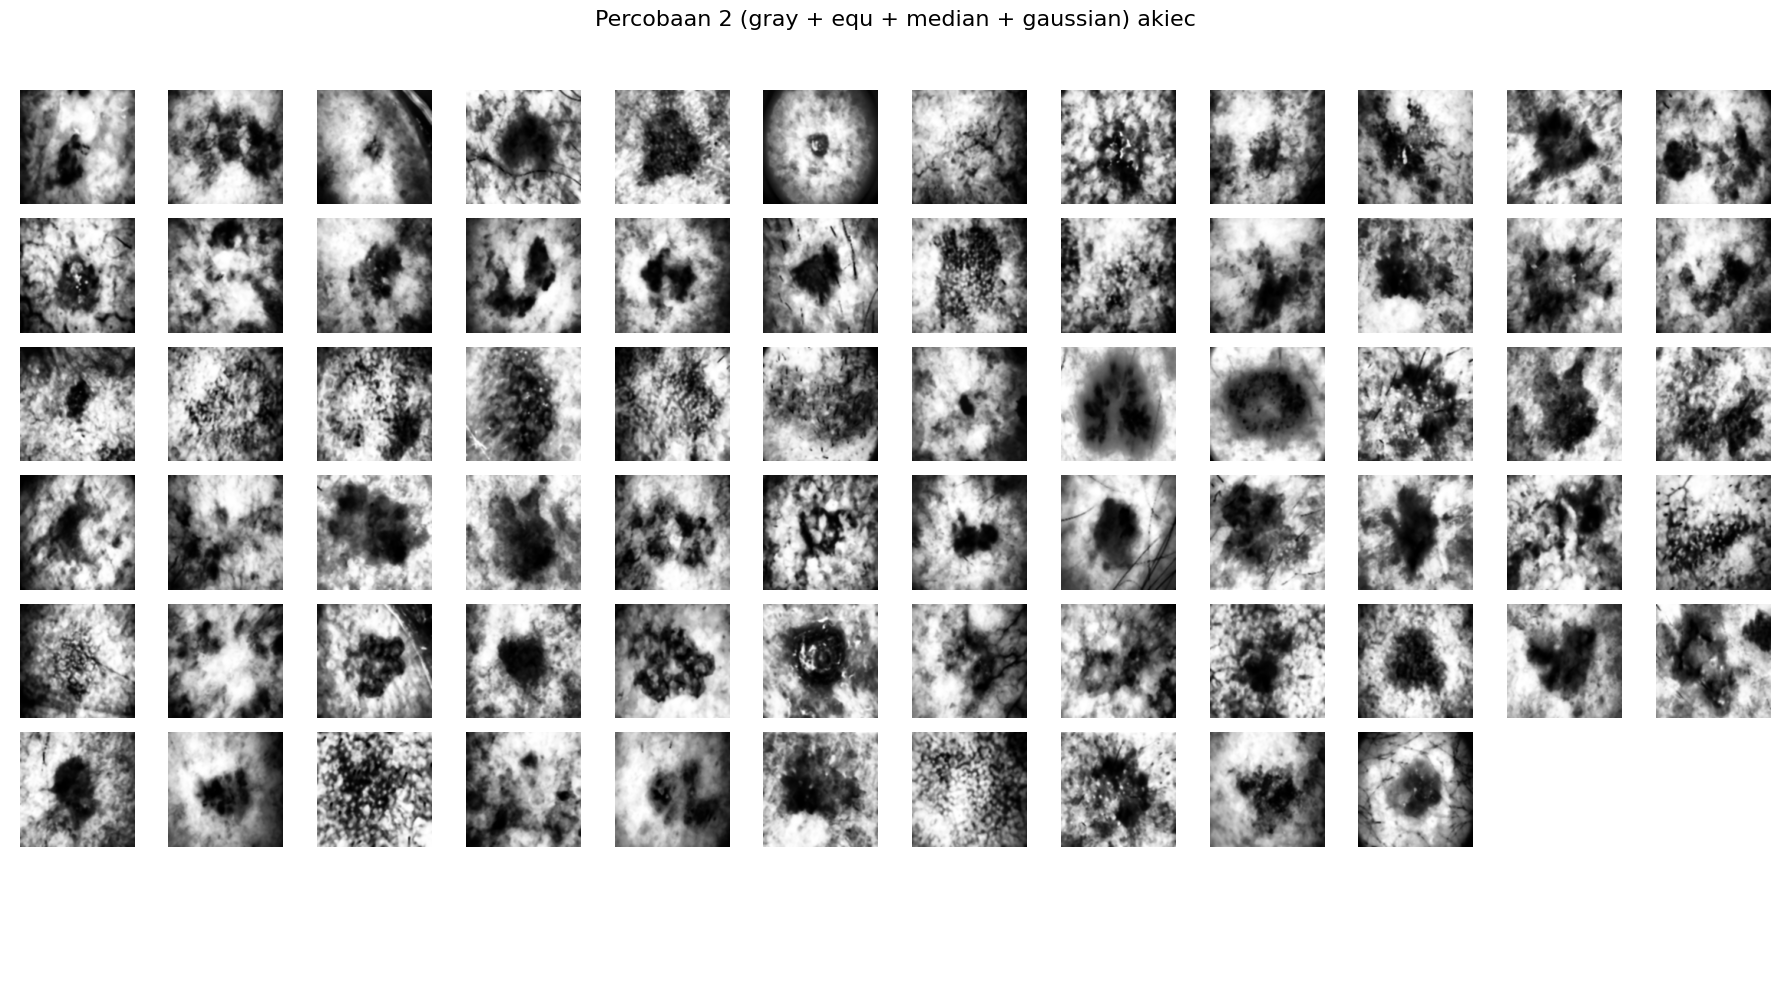

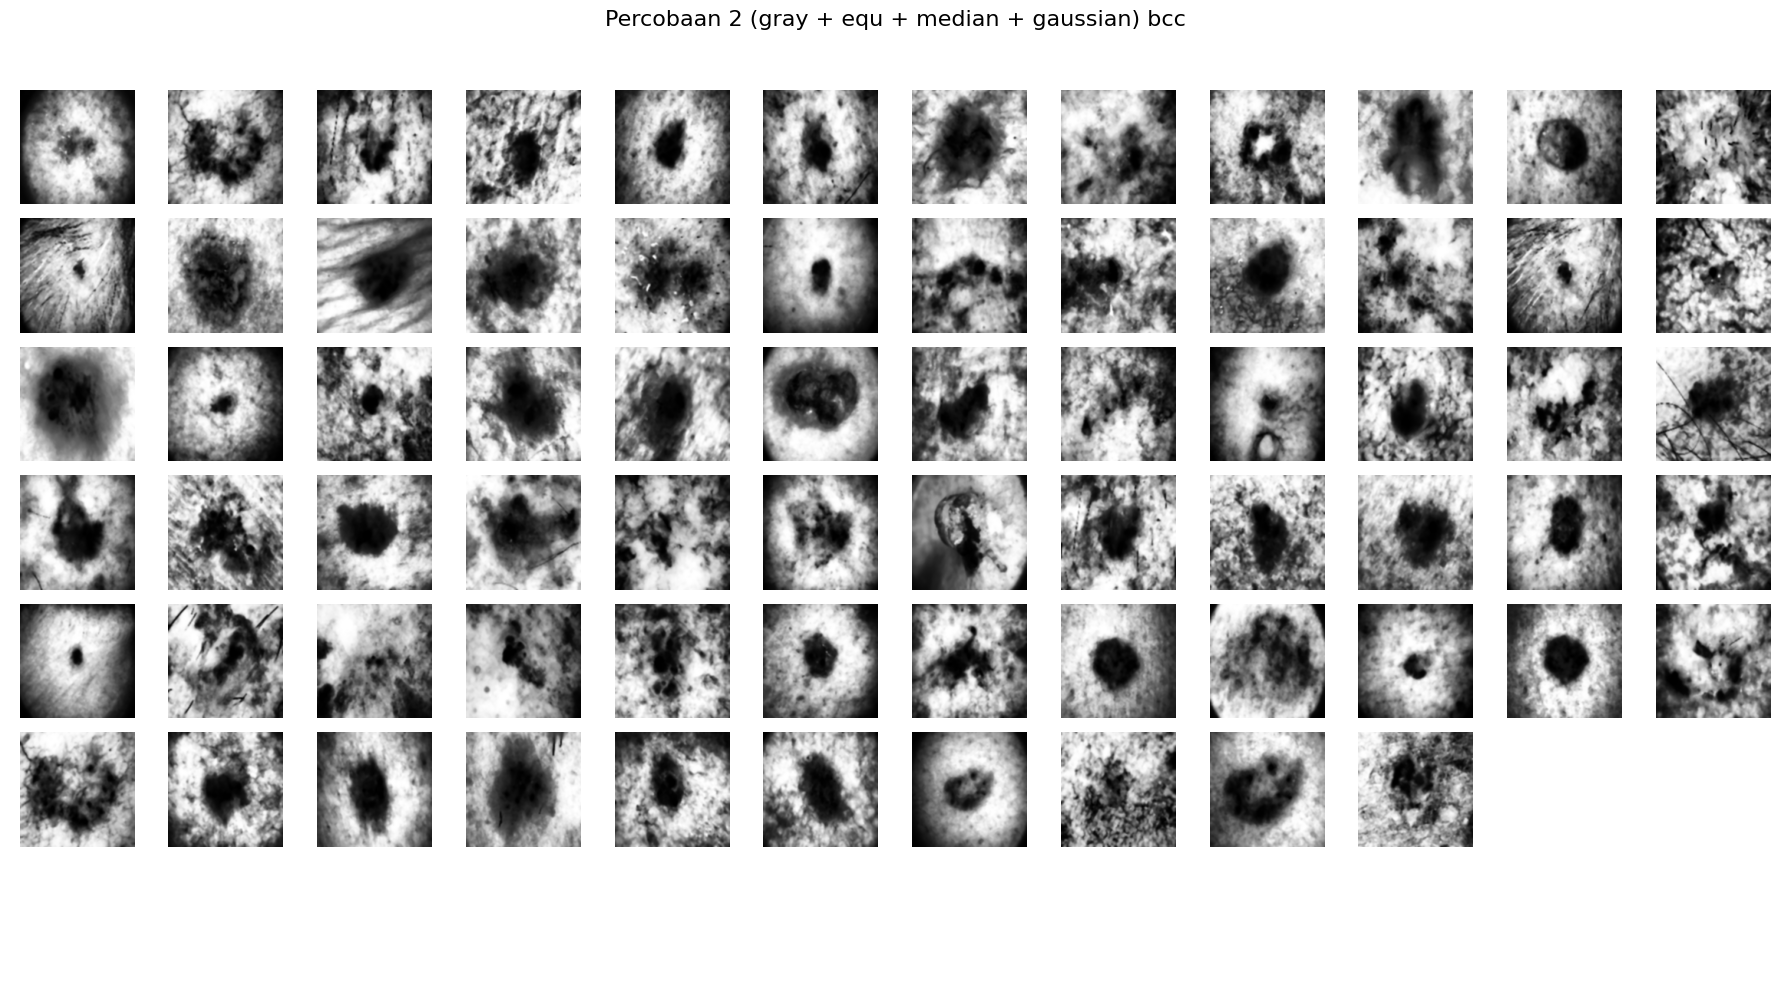

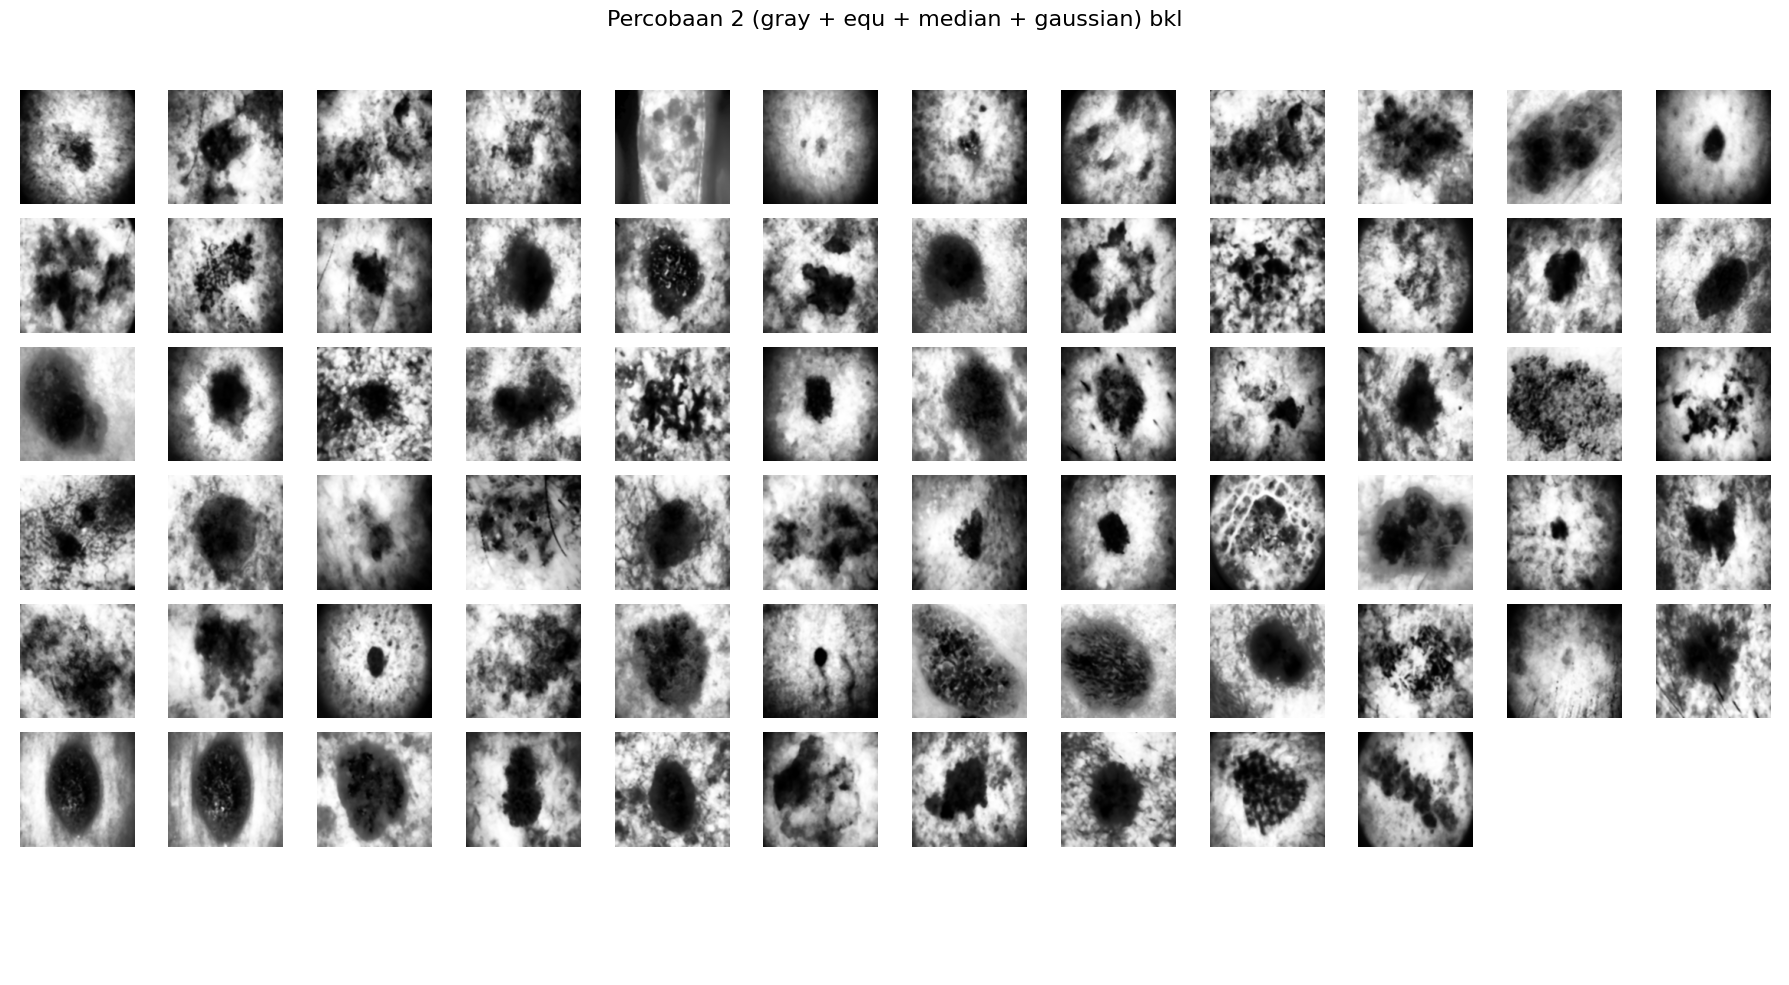

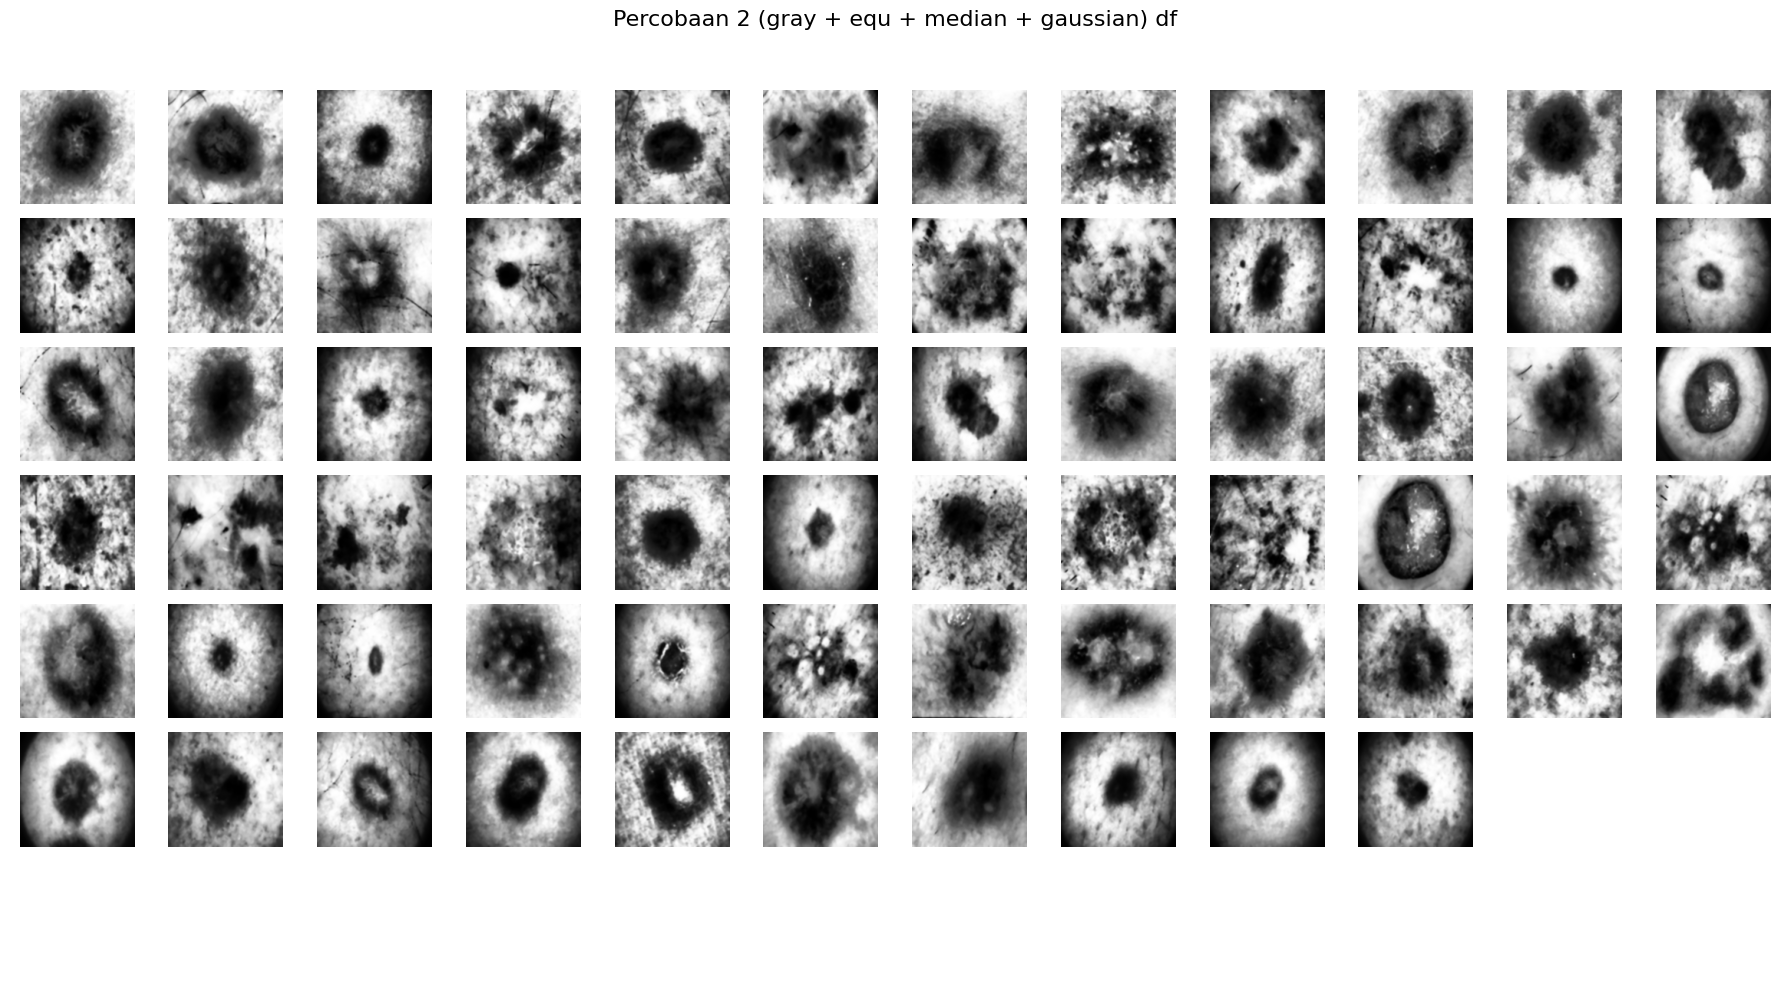

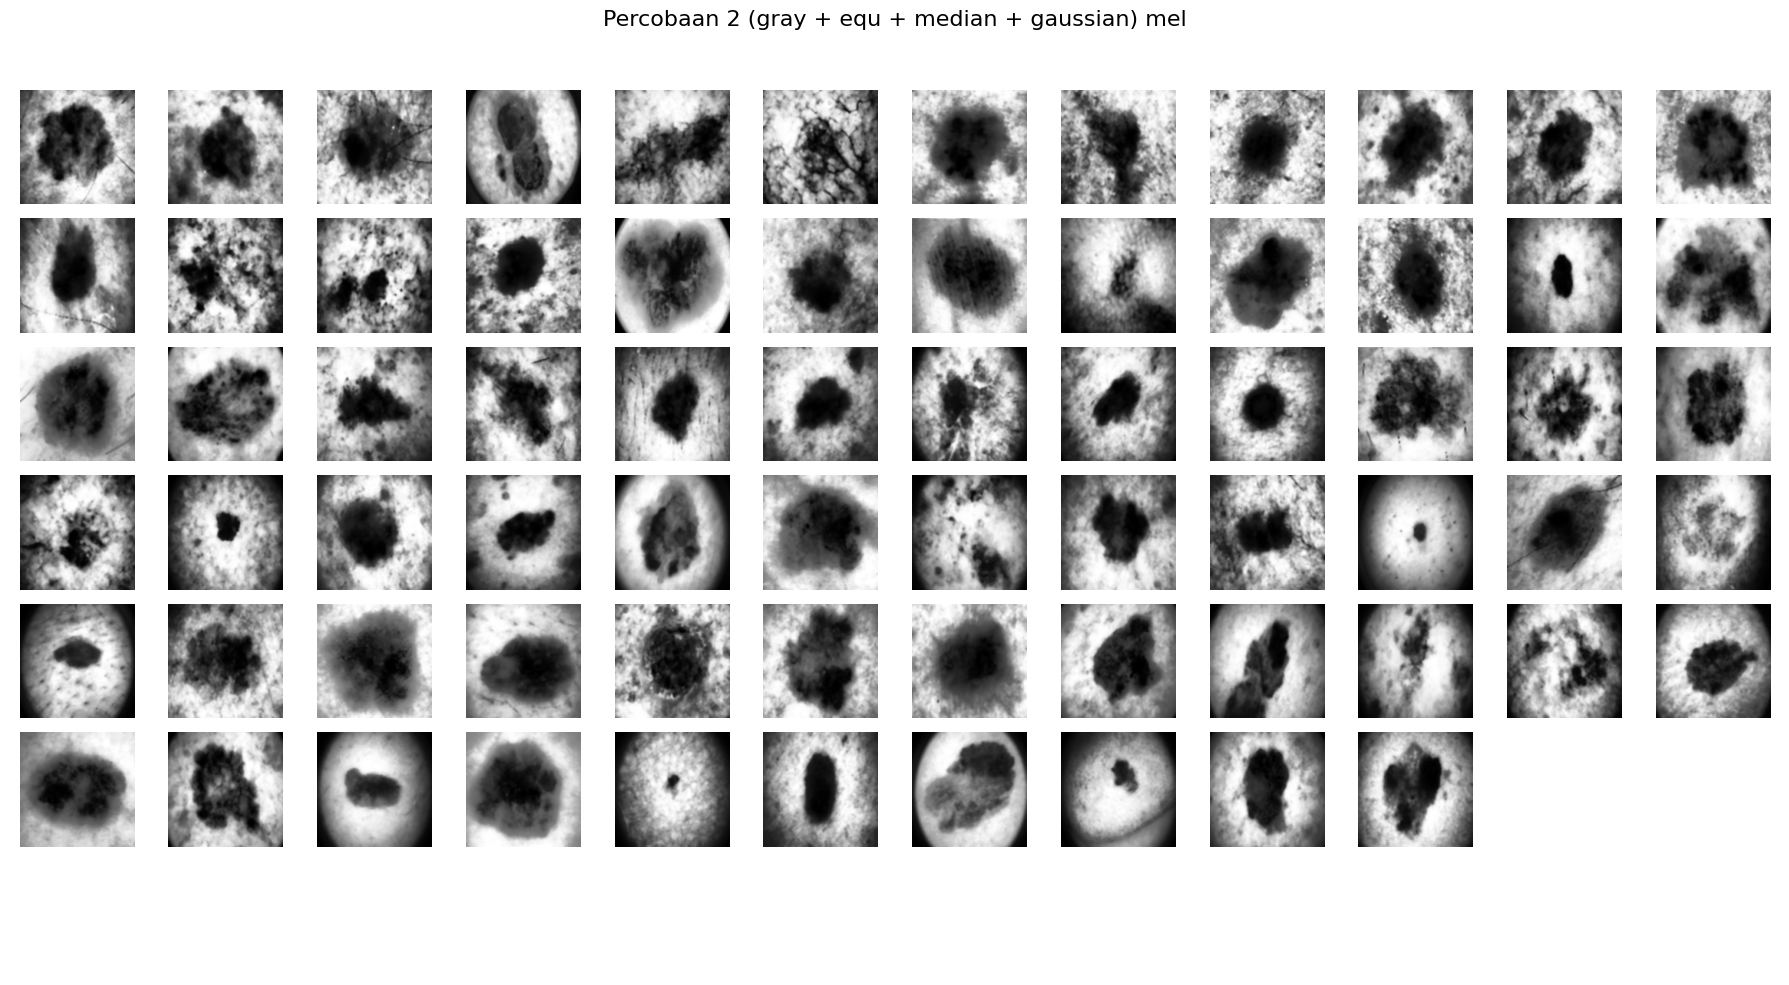

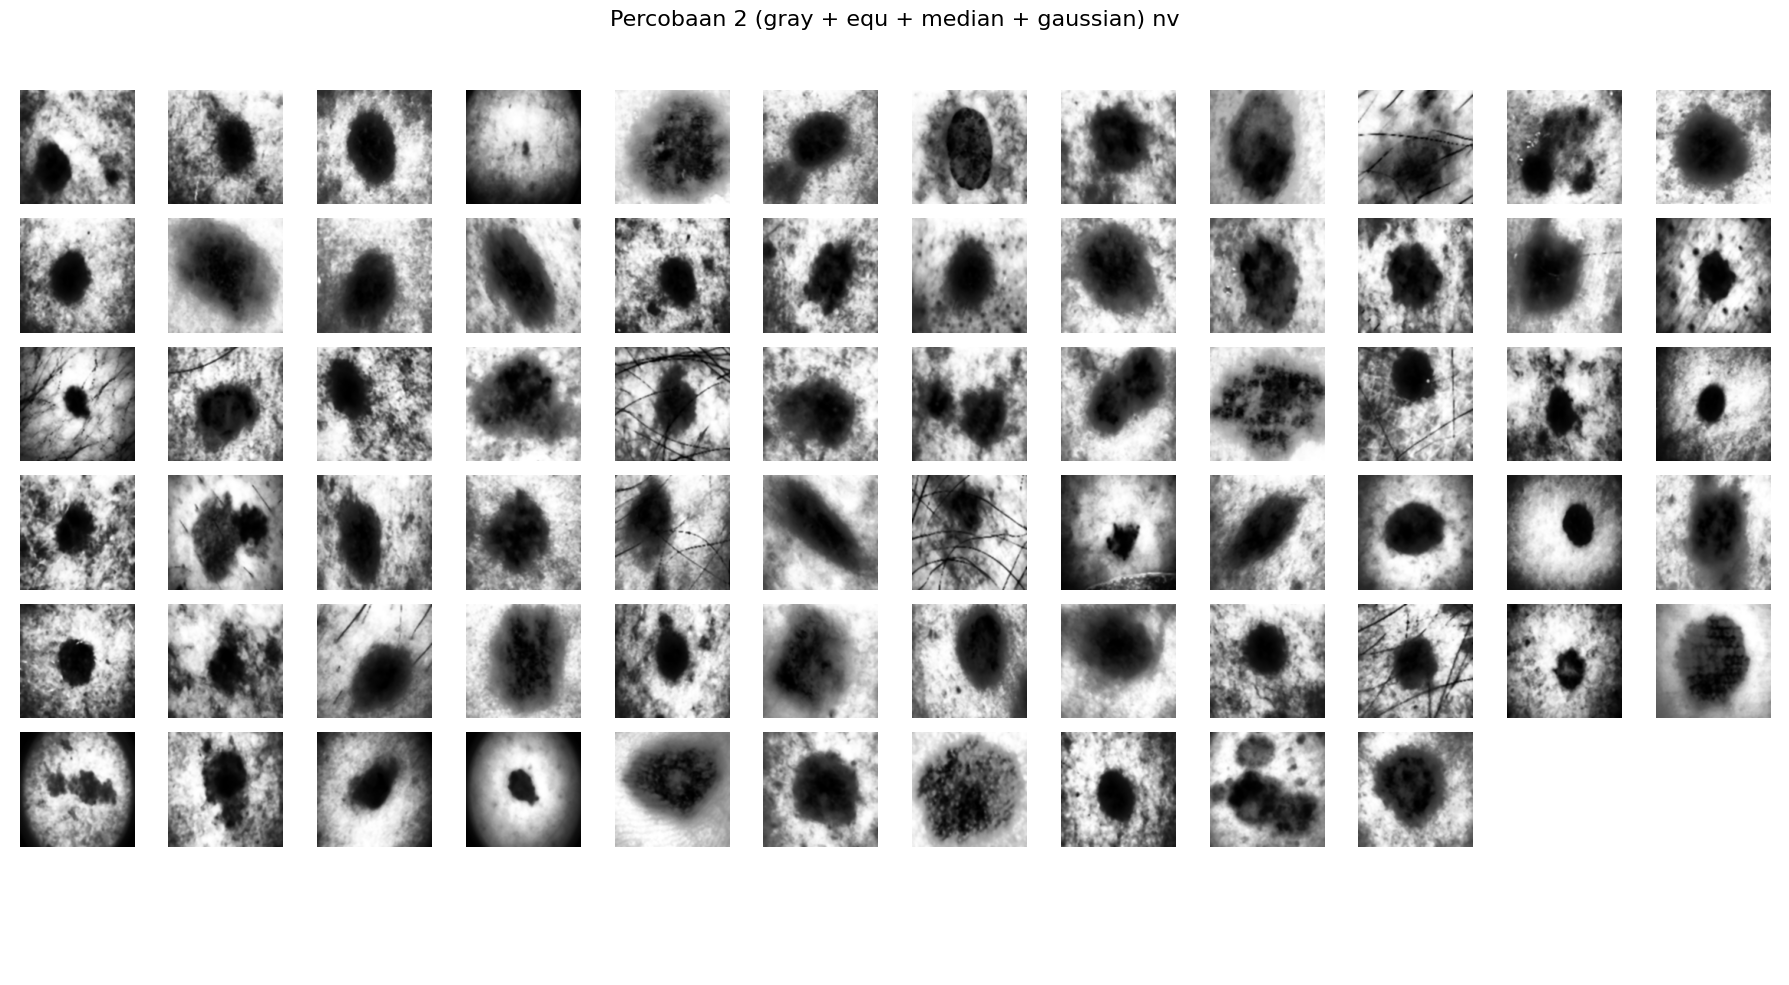

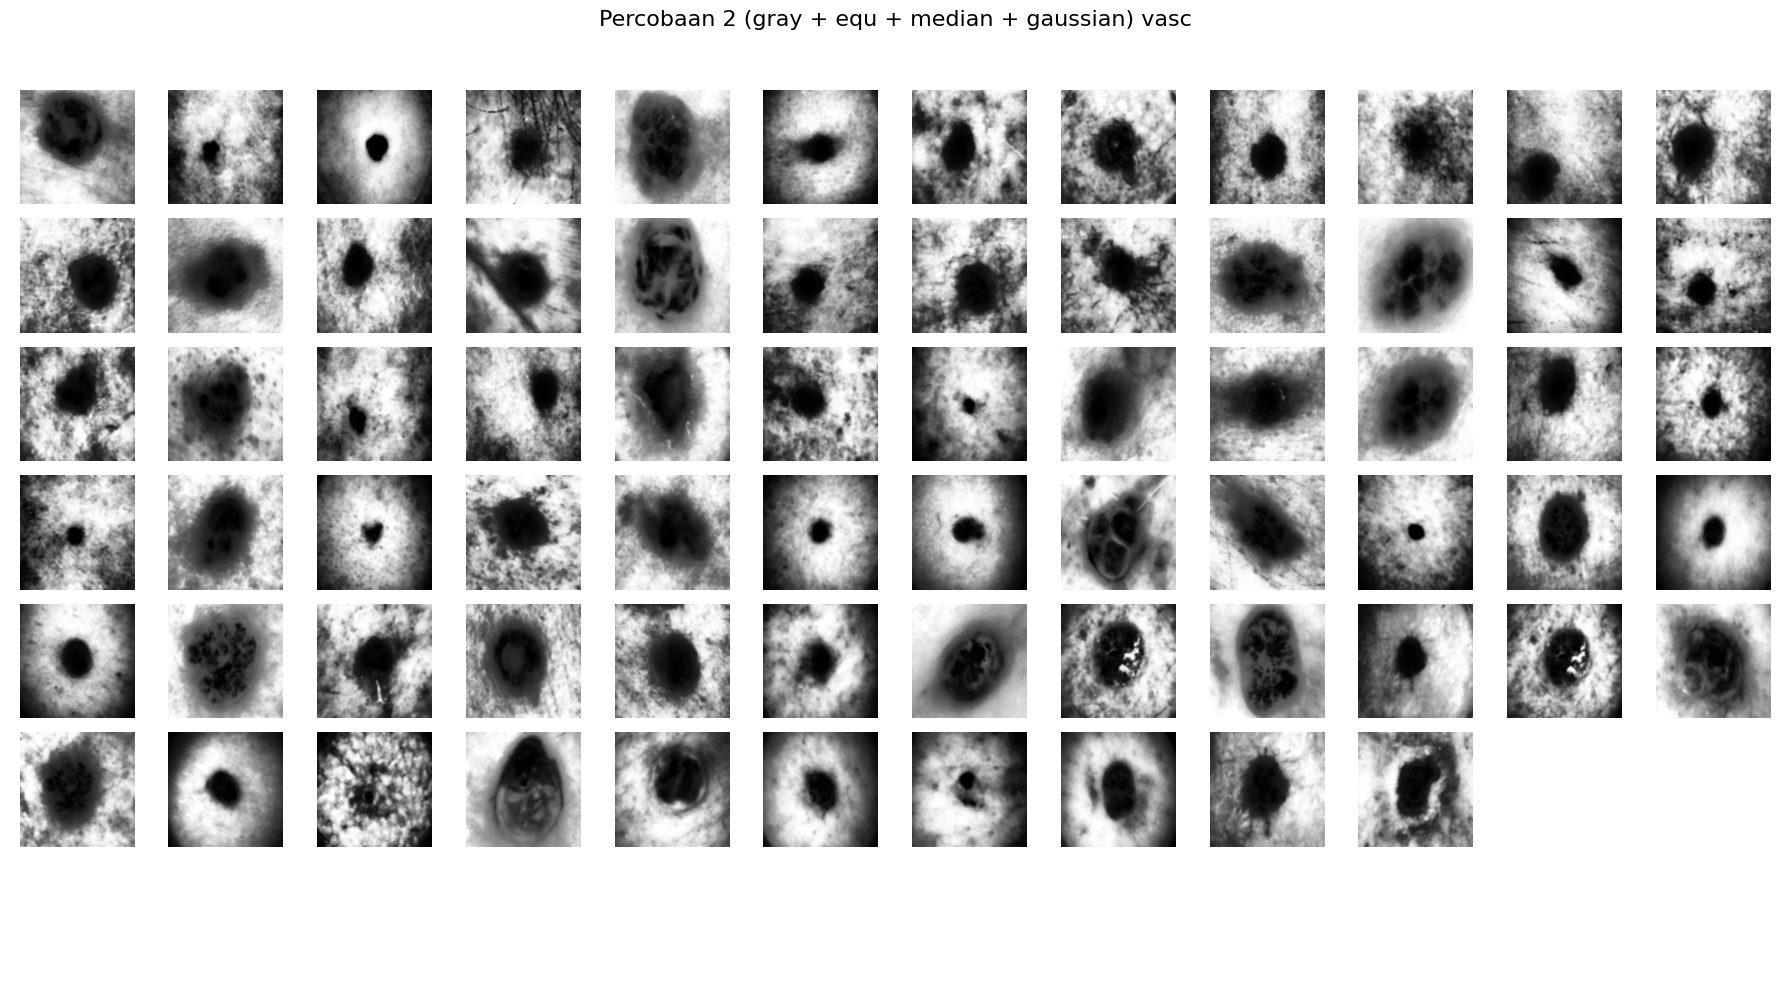

In [15]:
# Gaussian kernel 3x3
gaussian_kernel = (1/16) * np.array([[1, 2, 1],
                                     [2, 4, 2],
                                     [1, 2, 1]])

def percobaan2(gray):
    img_eq = histogram_equalization(gray)
    img_median = filter_median(img_eq, np.ones((3, 3), dtype=np.uint8))
    img_gaus = filter_image(img_median, gaussian_kernel)
    return img_gaus

dataPreprocessed = [percobaan2(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    idxs = [j for j, l in enumerate(labels) if l == label]
    n_imgs = len(idxs)
    n_rows, n_cols = 7, 12
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(18, 10))
    fig.suptitle(f'Percobaan 2 (gray + equ + median + gaussian) {label}', fontsize=16)
    
    for k in range(n_rows * n_cols):
        row = k // n_cols
        col = k % n_cols
        ax = axs[row][col]
        if k < n_imgs:
            ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    plt.show()


## Ekstraksi Fitur

In [ ]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    
    return glcm

In [ ]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [ ]:
# Fungsi ekstraksi fitur untuk list citra
def ekstrak_fitur_glcm(data, nama_prepro):
    fitur_list = []
    for img in data:
        img_u8 = img.astype(np.uint8)
        m = glcm(img_u8, 0)  # derajat 0
        
        fitur = {
            'contrast': contrast(m),
            'correlation': correlation(m),
            'energy': energy(m),
            'homogeneity': homogenity(m),
            'dissimilarity': dissimilarity(m),
            'ASM': ASM(m),
            'entropy': entropyGlcm(m)
        }
        fitur_list.append(fitur)

    df = pd.DataFrame(fitur_list)
    df['tahap'] = nama_prepro
    return df

df2 = ekstrak_fitur_glcm(dataPreprocessed, 'percobaan6')
display(df2)

contrast  correlation    energy  homogeneity  dissimilarity       ASM  \
0    124.445324     0.988577  0.054624     0.333377       7.104474  0.002984   
1    173.811275     0.983902  0.051192     0.314996       8.296376  0.002621   
2    121.346488     0.989058  0.050531     0.353970       6.423624  0.002553   
3    381.539553     0.963347  0.045201     0.285216      11.726219  0.002043   
4    291.167427     0.973269  0.090175     0.371631      10.831141  0.008131   
..          ...          ...       ...          ...            ...       ...   
485   59.590380     0.994639  0.040956     0.321917       4.946801  0.001677   
486   62.773960     0.994260  0.054915     0.382383       4.972975  0.003016   
487   70.960447     0.993694  0.054700     0.337629       5.456286  0.002992   
488  107.291544     0.990548  0.105015     0.485565       6.099597  0.011028   
489  163.500671     0.985169  0.052449     0.350743       7.565727  0.002751   

      entropy       tahap  
0    6.305768  percobaan6  
1    6.468494  percobaan6  
2    6.593851  percobaan6  
3    6.847976  percobaan6  
4    5.394051  percobaan6  
..        ...         ...  
485  6.898008  percobaan6  
486  6.222012  percobaan6  
487  6.416376  percobaan6  
488  5.168336  percobaan6  
489  6.443283  percobaan6  

[490 rows x 8 columns]

In [ ]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)



## Hasil Ekstraksi to CSV

In [ ]:
features = []

for i in range(len(dataPreprocessed)):
    fitur = [
        contrast(Derajat0[i]), contrast(Derajat45[i]), contrast(Derajat90[i]), contrast(Derajat135[i]),
        dissimilarity(Derajat0[i]), dissimilarity(Derajat45[i]), dissimilarity(Derajat90[i]), dissimilarity(Derajat135[i]),
        homogenity(Derajat0[i]), homogenity(Derajat45[i]), homogenity(Derajat90[i]), homogenity(Derajat135[i]),
        entropyGlcm(Derajat0[i]), entropyGlcm(Derajat45[i]), entropyGlcm(Derajat90[i]), entropyGlcm(Derajat135[i]),
        ASM(Derajat0[i]), ASM(Derajat45[i]), ASM(Derajat90[i]), ASM(Derajat135[i]),
        energy(Derajat0[i]), energy(Derajat45[i]), energy(Derajat90[i]), energy(Derajat135[i]),
        correlation(Derajat0[i]), correlation(Derajat45[i]), correlation(Derajat90[i]), correlation(Derajat135[i]),
    ]
    features.append(fitur)

# Buat dataframe
columns = [
    "contrast_0", "contrast_45", "contrast_90", "contrast_135",
    "dissimilarity_0", "dissimilarity_45", "dissimilarity_90", "dissimilarity_135",
    "homogeneity_0", "homogeneity_45", "homogeneity_90", "homogeneity_135",
    "entropy_0", "entropy_45", "entropy_90", "entropy_135",
    "ASM_0", "ASM_45", "ASM_90", "ASM_135",
    "energy_0", "energy_45", "energy_90", "energy_135",
    "correlation_0", "correlation_45", "correlation_90", "correlation_135"
]

df_fitur = pd.DataFrame(features, columns=columns)


In [ ]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_percobaan6.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_percobaan6.csv')
hasilEkstrak


Filename  Label   Contrast0  Contrast45  Contrast90  Contrast135  \
0    ISIC_0024329.jpg  akiec  124.445324  193.792982   91.991902   177.443854   
1    ISIC_0024463.jpg  akiec  173.811275  280.277825  143.853468   256.772217   
2    ISIC_0024511.jpg  akiec  121.346488  121.708572   88.353557   212.941804   
3    ISIC_0024562.jpg  akiec  381.539553  460.269267  337.311991   684.212648   
4    ISIC_0024646.jpg  akiec  291.167427  472.776812  276.490112   449.245079   
..                ...    ...         ...         ...         ...          ...   
485  ISIC_0033458.jpg   vasc   59.590380   77.404531   38.895436    92.352101   
486  ISIC_0033817.jpg   vasc   62.773960  103.375929   63.252125   113.962975   
487  ISIC_0033969.jpg   vasc   70.960447   84.572046   42.671454   113.248773   
488  ISIC_0033991.jpg   vasc  107.291544  161.392460   75.835615   136.048782   
489  ISIC_0034196.jpg   vasc  163.500671  256.001486  110.183400   213.787262   

     Homogeneity0  Homogeneity45  Homogeneity90  Homogeneity135  ...  \
0        0.333377       0.262417       0.379283        0.276288  ...   
1        0.314996       0.241302       0.337019        0.249643  ...   
2        0.353970       0.312841       0.390815        0.274940  ...   
3        0.285216       0.229120       0.314136        0.204405  ...   
4        0.371631       0.284122       0.375737        0.285292  ...   
..            ...            ...            ...             ...  ...   
485      0.321917       0.289076       0.425885        0.271563  ...   
486      0.382383       0.315207       0.411185        0.302922  ...   
487      0.337629       0.305835       0.437599        0.287294  ...   
488      0.485565       0.407020       0.551550        0.422416  ...   
489      0.350743       0.275821       0.400182        0.286220  ...   

        ASM90    ASM135   Energy0  Energy45  Energy90  Energy135  \
0    0.003516  0.002403  0.054624  0.047509  0.059298   0.049018   
1    0.002850  0.002014  0.051192  0.043806  0.053381   0.044875   
2    0.002892  0.001900  0.050531  0.046149  0.053777   0.043583   
3    0.002393  0.001423  0.045201  0.040653  0.048919   0.037720   
4    0.008317  0.006152  0.090175  0.077533  0.091196   0.078432   
..        ...       ...       ...       ...       ...        ...   
485  0.002172  0.001285  0.040956  0.037620  0.046606   0.035851   
486  0.003176  0.002211  0.054915  0.048311  0.056356   0.047023   
487  0.003856  0.002346  0.054700  0.051238  0.062096   0.048434   
488  0.012849  0.009311  0.105015  0.094152  0.113355   0.096492   
489  0.003395  0.002165  0.052449  0.045841  0.058263   0.046531   

     Correlation0  Correlation45  Correlation90  Correlation135  
0        0.988577       0.982207       0.991579        0.983707  
1        0.983902       0.974051       0.986650        0.976228  
2        0.989058       0.989031       0.992064        0.980809  
3        0.963347       0.955711       0.967484        0.934157  
4        0.973269       0.956610       0.974528        0.958769  
..            ...            ...            ...             ...  
485      0.994639       0.993035       0.996517        0.991691  
486      0.994260       0.990535       0.994240        0.989565  
487      0.993694       0.992479       0.996218        0.989929  
488      0.990548       0.985819       0.993332        0.988046  
489      0.985169       0.976875       0.990064        0.980689  

[490 rows x 30 columns]

## Feature Selection

### Correlation

<Axes: >

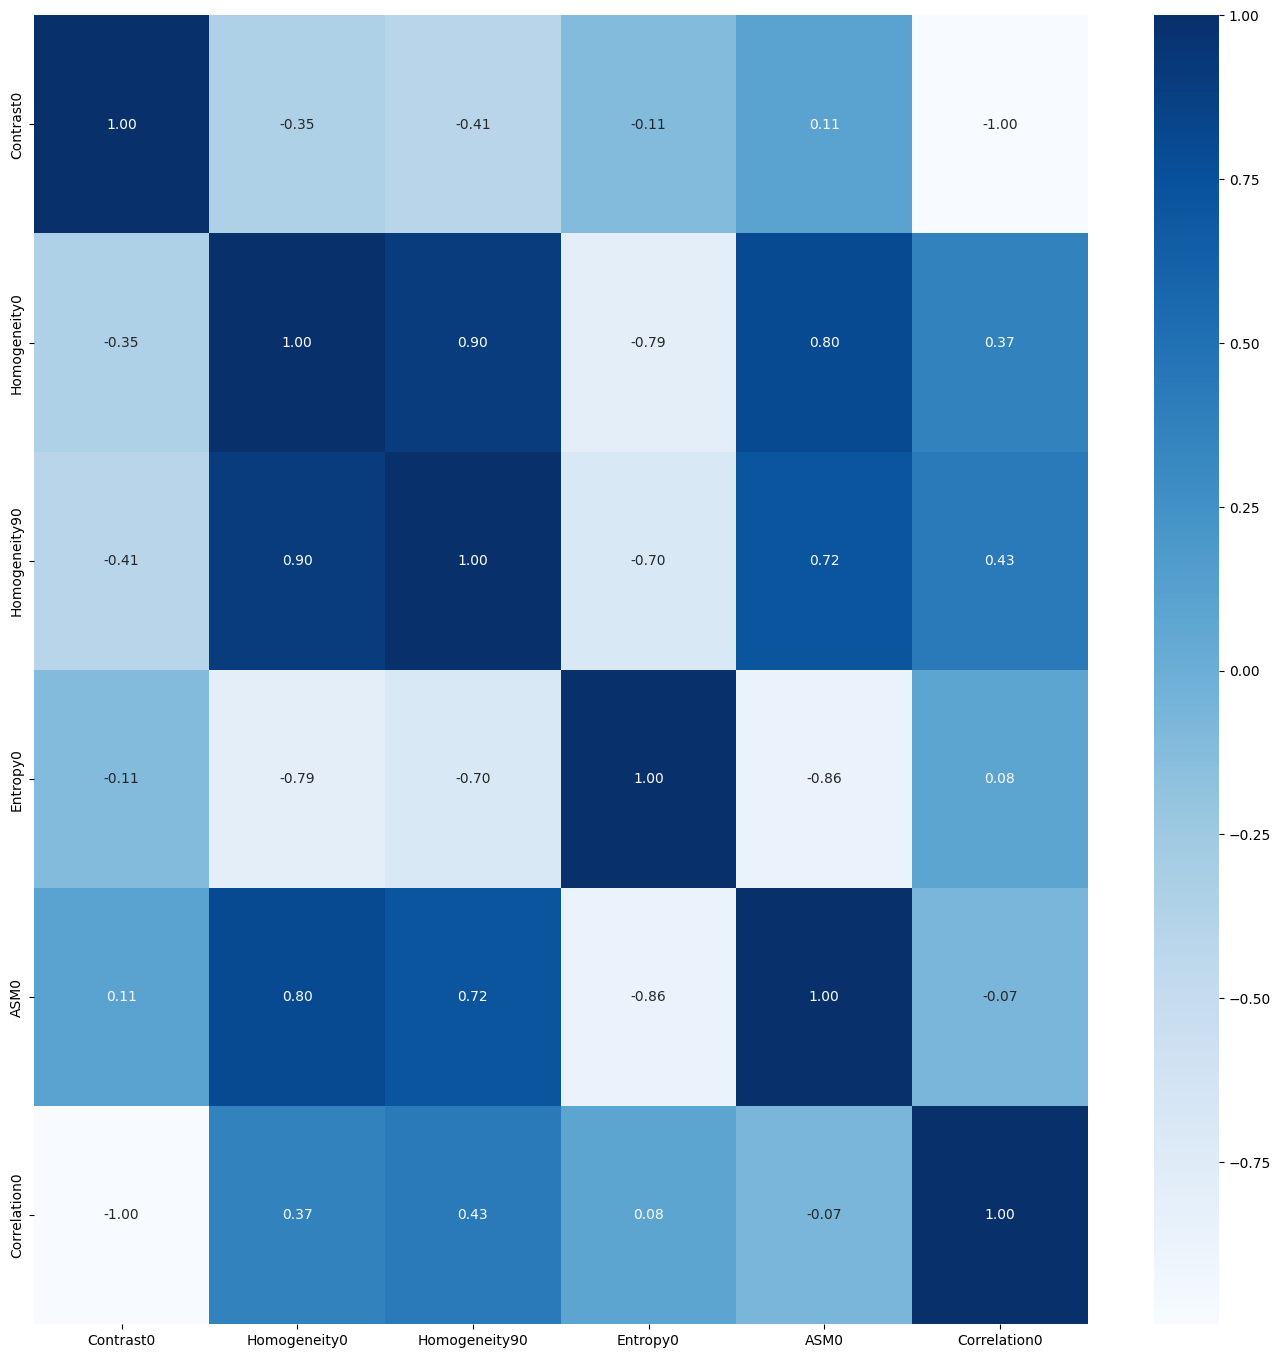

In [ ]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### LDA

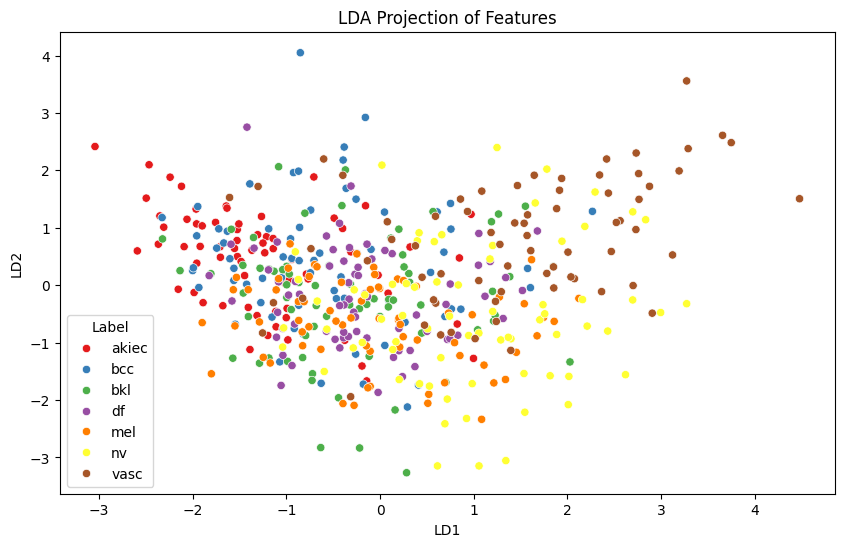

In [ ]:
# Selection LDA

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

def feature_reduction_lda(dataframe, n_components=2):
    fitur = dataframe.drop(columns=['Label', 'Filename'])
    label = dataframe['Label']
    
    lda = LinearDiscriminantAnalysis(n_components=n_components)
    x_lda = lda.fit_transform(fitur, label)
    
    columns = [f'LD{i+1}' for i in range(n_components)]
    df_lda = pd.DataFrame(x_lda, columns=columns)
    df_lda['Label'] = label.values
    
    return df_lda

lda_df = feature_reduction_lda(hasilEkstrak, n_components=2)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=lda_df, x='LD1', y='LD2', hue='Label', palette='Set1')
plt.title('LDA Projection of Features')
plt.xlabel('LD1')
plt.ylabel('LD2')
plt.legend(title='Label')
plt.show()

### t-SNE

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


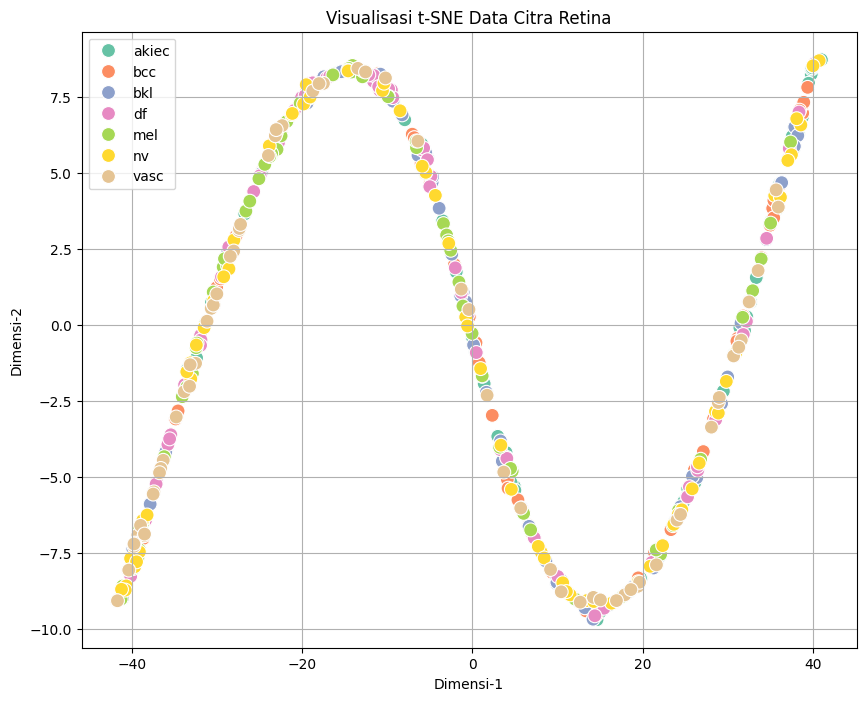

In [ ]:
# Selection t-SNE

from sklearn.manifold import TSNE

# Jalankan t-SNE untuk reduksi ke 2 dimensi
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(x_new)

# Buat DataFrame hasil t-SNE
df_tsne = pd.DataFrame()
df_tsne['Dimensi-1'] = X_tsne[:, 0]
df_tsne['Dimensi-2'] = X_tsne[:, 1]
df_tsne['Label'] = y

# Plot dengan seaborn
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Dimensi-1', y='Dimensi-2', hue='Label', data=df_tsne, palette='Set2', s=100
)
plt.title('Visualisasi t-SNE Data Citra Retina')
plt.legend(loc='best')
plt.grid(True)
plt.show()


## Splitting Data

In [ ]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(392, 6)
(98, 6)
(392,)
(98,)


## Feature Normalization

In [ ]:
# normalisasi mean std (Standardization / Z-score normalization)
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [ ]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [ ]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

       akiec       0.86      0.96      0.91        57
         bcc       0.91      0.84      0.88        51
         bkl       0.85      0.92      0.88        60
          df       0.89      0.92      0.90        61
         mel       0.91      0.93      0.92        56
          nv       1.00      0.80      0.89        59
        vasc       0.98      1.00      0.99        48

    accuracy                           0.91       392
   macro avg       0.91      0.91      0.91       392
weighted avg       0.91      0.91      0.91       392

[[55  0  1  0  1  0  0]
 [ 3 43  1  2  2  0  0]
 [ 1  1 55  3  0  0  0]
 [ 2  0  3 56  0  0  0]
 [ 1  1  2  0 52  0  0]
 [ 2  2  3  2  2 47  1]
 [ 0  0  0  0  0  0 48]]
Accuracy: 0.9081632653061225

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.41      0.54      0.47        13
         bcc       0.19      0.16      0.17   

### Train SVM Classifier

In [ ]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

       akiec       0.40      0.72      0.51        57
         bcc       0.00      0.00      0.00        51
         bkl       0.40      0.20      0.27        60
          df       0.33      0.43      0.37        61
         mel       0.41      0.46      0.44        56
          nv       0.34      0.46      0.39        59
        vasc       0.49      0.38      0.42        48

    accuracy                           0.38       392
   macro avg       0.34      0.38      0.34       392
weighted avg       0.34      0.38      0.35       392

[[41  0  3  8  2  2  1]
 [20  0  2 12  5  9  3]
 [18  0 12 12  7  9  2]
 [12  0  2 26  9  9  3]
 [ 8  0  4  7 26 10  1]
 [ 2  0  6  5 10 27  9]
 [ 2  0  1  9  4 14 18]]
Accuracy: 0.3826530612244898

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.36      0.77      0.49        13
         bcc       0.00      0.00      0.00  

c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

### Train KNN Classifier

In [ ]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

       akiec       0.46      0.67      0.54        57
         bcc       0.44      0.43      0.44        51
         bkl       0.45      0.45      0.45        60
          df       0.45      0.54      0.49        61
         mel       0.51      0.39      0.44        56
          nv       0.55      0.47      0.51        59
        vasc       0.66      0.44      0.53        48

    accuracy                           0.49       392
   macro avg       0.50      0.48      0.49       392
weighted avg       0.50      0.49      0.49       392

[[38  2  5  8  1  2  1]
 [13 22  5  4  4  2  1]
 [13  6 27  6  4  2  2]
 [ 6  2  8 33  7  3  2]
 [ 4 11  2 10 22  5  2]
 [ 6  6  8  4  4 28  3]
 [ 3  1  5  8  1  9 21]]
Accuracy: 0.4872448979591837

------Testing Set------
              precision    recall  f1-score   support

       akiec       0.29      0.54      0.38        13
         bcc       0.19      0.16      0.17  

## Evaluasi Dengan Confussion Matrix

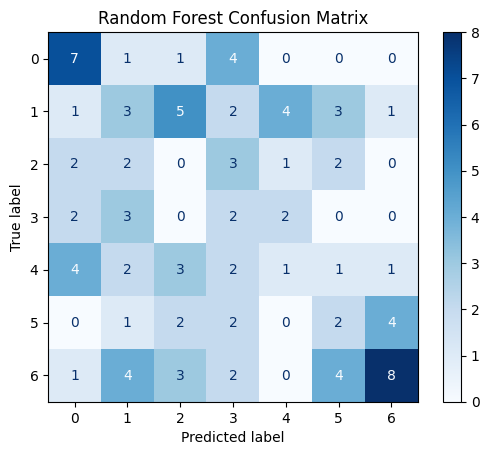

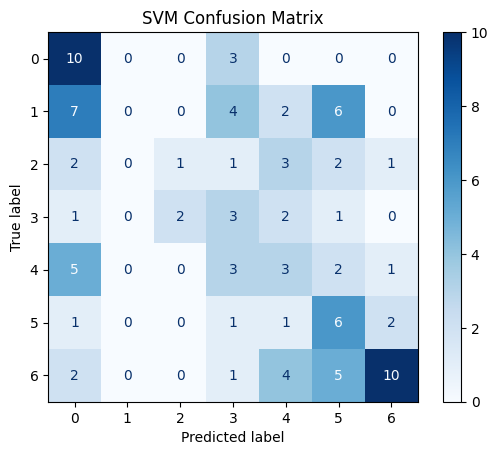

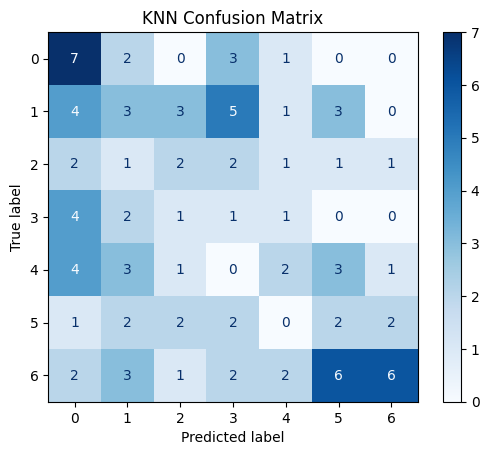

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")